In [1]:
from casatasks import *
from casatools import ms, table, msmetadata
from pathlib import Path
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np

In [2]:
path = "/home/noedia/scratch/interferometry/HTLup_continuum.ms"

mset = ms()
tb = table()
msmd = msmetadata()

# Getting the
tb.open(path)
cols = tb.colnames()
data = tb.getcol("DATA") # complex of shape (npol, nchannels, N_vis) 
u, v, w = tb.getcol("UVW") # meters
#spw_id = tb.getcol("SPECTRAL_WINDOW_ID") 
print(cols)
tb.close()

spw_id = 1
msmd.open(path)
spws = msmd.datadescids()
chan_freq = msmd.chanfreqs(spw_id) # frequencies in Hertz, in each channel
nchan = len(chan_freq) # number of channels
print(nchan)
msmd.done()


['UVW', 'FLAG', 'FLAG_CATEGORY', 'WEIGHT', 'SIGMA', 'ANTENNA1', 'ANTENNA2', 'ARRAY_ID', 'DATA_DESC_ID', 'EXPOSURE', 'FEED1', 'FEED2', 'FIELD_ID', 'FLAG_ROW', 'INTERVAL', 'OBSERVATION_ID', 'PROCESSOR_ID', 'SCAN_NUMBER', 'STATE_ID', 'TIME', 'TIME_CENTROID', 'DATA', 'WEIGHT_SPECTRUM', 'SIGMA_SPECTRUM', 'MODEL_DATA']
16


True

Problem: Not the same number of frequencies for each spectral window (alternates between 8 and 16 as seen below)

In [28]:
chan_freq

array([2.33542496e+11, 2.33417496e+11, 2.33292496e+11, 2.33167496e+11,
       2.33042496e+11, 2.32917496e+11, 2.32792496e+11, 2.32667496e+11,
       2.32542496e+11, 2.32417496e+11, 2.32292496e+11, 2.32167496e+11,
       2.32042496e+11, 2.31917496e+11, 2.31792496e+11, 2.31667496e+11])

In [23]:
chan_freq

array([2.30953108e+11, 2.30835921e+11, 2.30718733e+11, 2.30601546e+11,
       2.30484358e+11, 2.30367171e+11, 2.30249983e+11, 2.30132796e+11])

### u-v coverage: 
Plotting in meters

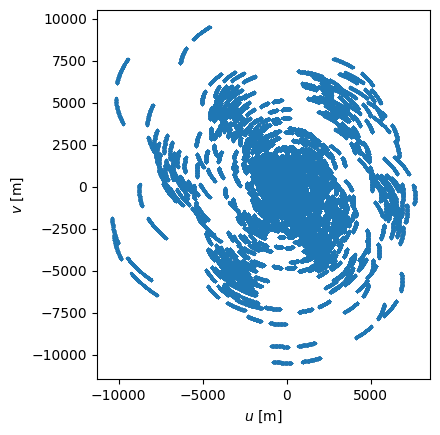

In [3]:
plt.scatter(u, v, s = 1.5)
plt.xlabel(r"$u$ [m]")
plt.ylabel(r"$v$ [m]")
plt.gca().set_aspect("equal")

Plotting in kilolambda

Shape of data: (pol, frequencies, N_vis)

In [10]:
data.shape

(2, 8, 2388368)

In [4]:
mset.open(path)
d = mset.getdata(["real", "imaginary"])
vis_real = d['real']
vis_imaginary = d['imaginary']
vis = vis_real + 1j * vis_imaginary
print(vis.shape)

(2, 8, 40152)


2023-08-01 18:15:37	WARN	ms::checkinit	Data shape varies, selecting first data desc id only


In [13]:
vis_amplitude.shape

(2, 8, 40152)

`ms` class from casatools not working with this measurement set.  
`exportuvfits` > error  
`listvis` > not working

In [5]:
import sys
sys.path.append("../scripts/")
from utils import resize

def export_fits(image_name, dirty=False, overwrite=True):
    if dirty:
        exportfits(
            imagename=f"{image_name}.image",
            fitsimage=f"{image_name}.fits",
            overwrite=overwrite
        )
    else: 
        exportfits(
            imagename=f"{image_name}.image.tt0",
            fitsimage=f"{image_name}.fits",
            overwrite=overwrite
        )

In [6]:
# Path to your .fits file
image_name = "/home/noedia/scratch/interferometry/HTLup_continuum"

export_fits(image_name, dirty = True, overwrite = True) # Create a fits file for the dirty image

In [47]:
path = image_name + ".fits"

with fits.open(path) as hdul: 
    header = hdul[0].header
    data = hdul[0].data
    print(header)
    print(data.shape)

dirty_image = data[0, 0]
dirty_resized = resize(dirty_image, target_size = 64) # Crop the image around the center
vis_gridded = np.fft.fft2(dirty_resized, norm = "ortho")

SIMPLE  =                    T /Standard FITS                                   BITPIX  =                  -32 /Floating point (32 bit)                         NAXIS   =                    4                                                  NAXIS1  =                  256                                                  NAXIS2  =                  256                                                  NAXIS3  =                    1                                                  NAXIS4  =                    1                                                  EXTEND  =                    T                                                  BSCALE  =   1.000000000000E+00 /PHYSICAL = PIXEL*BSCALE + BZERO                 BZERO   =   0.000000000000E+00                                                  BMAJ    =   2.362889962064E-05                                                  BMIN    =   1.588312909007E-05                                                  BPA     =   5.916762161255E+01          

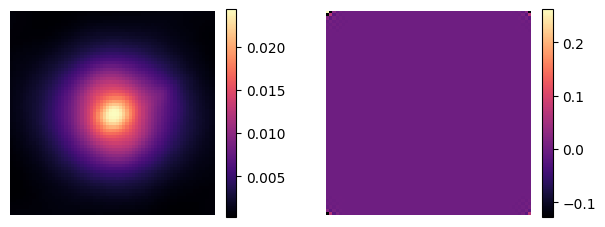

In [48]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (7, 3.5))

# Disabling axes: 
for i in range(len(axs)): 
    axs[i].axis("off")


im = axs[0].imshow(dirty_resized, cmap = "magma")
plt.colorbar(im, fraction = 0.046)

im = axs[1].imshow(vis_gridded.real, cmap = "magma")
plt.colorbar(im, fraction = 0.046)

plt.subplots_adjust(wspace = 0.4)

In [18]:
ls = vishead(path, mode = "list", listitems = [])

In [15]:
path = "HTLup_continuum.ms"
ms.open(path)

AttributeError: 'str' object has no attribute '_swigobj'

In [12]:

exportuvfits(path, "vis.fits",  multisource = False)

2023-07-31 19:17:54	WARN	exportuvfits::MSFitsOutput::write	Multiple sources are present, thus written as a multi-source FITS file
2023-07-31 19:17:54	SEVERE	exportuvfits::MSFitsOutput::_writeMain	Number of channels varies in the MS, i.e. the is more than one SPW shape!
2023-07-31 19:17:54	SEVERE	exportuvfits::MSFitsOutput::_writeMain+	Please split out SPWs of identical shape and export them separately.
2023-07-31 19:17:54	SEVERE	exportuvfits::ms::tofits	Exception Reported: Exception: Could not write main table
2023-07-31 19:17:54	SEVERE	exportuvfits::ms::tofits+	.
2023-07-31 19:17:54	SEVERE	exportuvfits::ms::tofits+	... thrown by void casa6core::MSFitsOutput::write() const at File: casacore/msfits/MSFits/MSFitsOutput.cc, line: 224
2023-07-31 19:17:54	SEVERE	exportuvfits::::casa	Task exportuvfits raised an exception of class RuntimeError with the following message: Exception: Could not write main table
2023-07-31 19:17:54	SEVERE	exportuvfits::::casa+	.
2023-07-31 19:17:54	SEVERE	exportu

RuntimeError: Exception: Could not write main table
.
... thrown by void casa6core::MSFitsOutput::write() const at File: casacore/msfits/MSFits/MSFitsOutput.cc, line: 224

In [17]:
LS = listvis(path, listfile = "test")

2023-07-31 18:23:10	SEVERE	listvis::ms::lister	Caught exception: File: test already exists; delete it or choose a different name.
2023-07-31 18:23:10	SEVERE	listvis::MSLister::list (file casacore/ms/MSOper/MSLister.cc, line 304)	Caught exception: Error in MSLister::listData
2023-07-31 18:23:10	SEVERE	listvis::ms::lister	Exception Reported: Error in MSLister::list
2023-07-31 18:23:10	SEVERE	listvis::::casa	Task listvis raised an exception of class RuntimeError with the following message: Error in MSLister::list


RuntimeError: Error in MSLister::list

In [3]:
!cat "HTLup_continuum.ms/table.info"

Type = Measurement Set
SubType = UVFITS

This is a MeasurementSet Table holding measurements from a Telescope
This is a measurement set Table holding astronomical observations


In [3]:
import csv

# read flash.dat to a list of lists

path = "HTLup_continuum.ms/OBSERVATION/table.dat"
datContent = [i.strip().split() for i in open(path).readlines()]

# write it as a new CSV file
with open(path, "wb") as f:
    writer = csv.writer(f)
    writer.writerows(datContent)

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xbe in position 0: invalid start byte

In [4]:
import numpy as np

x = np.fromfile()

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xbe in position 0: invalid start byte

In [8]:
!cat "HTLup_continuum.ms/OBSERVATION/table.info"

Type = 
SubType = 

